# Profiling bacterial abundance with Kraken2 and Bracken

## Preamble

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [34]:
bracken_db = '/u/thosi/dev/tmp/abundance.duckdb'

query = 'select "sample", "name", fraction_total_reads from abundance where fraction_total_reads > .1;'

with duckdb.connect(database=bracken_db, read_only=True) as con:
    data = con.sql(query).df()

In [35]:
data = data.sample(n=100).reset_index(drop=True).reset_index().pivot_table(index='index', columns='name', values='fraction_total_reads')
taxa = data.columns

<BarContainer object of 100 artists>

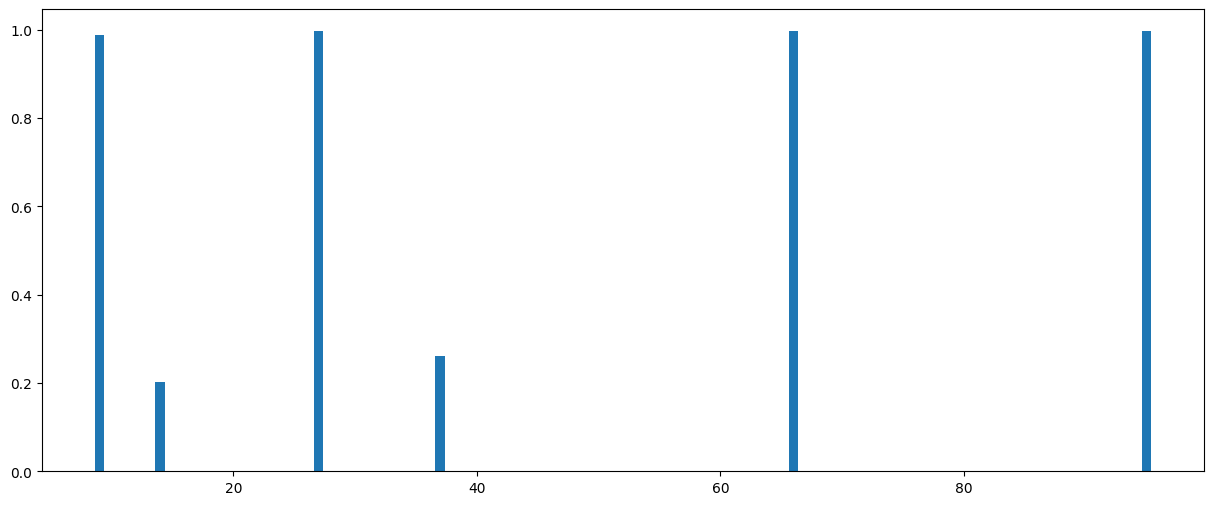

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))

taxon = taxa[0]
pltdata = data[taxon]
ax.bar(pltdata.index, pltdata)